# A1: Data Curation
___
## Step 1: Data Acquisition

In [1]:
import json
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = "25,10"
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.labelsize"] = 16

In [2]:
endpoint_pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access-site}/{agent}/{granularity}/{start}/{end}'


In [3]:
# counts parameters

params_count_desktop = {'project' : 'en.wikipedia.org',
                        'access-site' : 'desktop-site',
                        'granularity' : 'monthly',
                        'start' : '2007120100',
                        'end' : '2016070100'
                       }

params_count_all = {'project' : 'en.wikipedia.org',
                    'access-site' : 'all-sites',
                    'granularity' : 'monthly',
                    'start' : '2007120100',
                    'end' : '2016070100'
                   }

params_count_mobile = {'project' : 'en.wikipedia.org',
                       'access-site' : 'mobile-site',
                       'granularity' : 'monthly',
                       'start' : '2007120100',
                       'end' : '2016070100'
                      }

# views parameters
params_views_desktop = {'project' : 'en.wikipedia.org',
                        'access-site' : 'desktop',
                        'agent' : 'user',
                        'granularity' : 'monthly',
                        'start' : '2015070100',
                        'end' : '2021090100'
                       }

params_views_mobileweb = {'project' : 'en.wikipedia.org',
                          'access-site' : 'mobile-web',
                          'agent' : 'user',
                          'granularity' : 'monthly',
                          'start' : '2015070100',
                          'end' : '2021090100'
                         }

params_views_mobileapp = {'project' : 'en.wikipedia.org',
                          'access-site' : 'mobile-app',
                          'agent' : 'user',
                          'granularity' : 'monthly',
                          'start' : '2015070100',
                          'end' : '2021090100'
                         }

In [4]:
params_template = {'project' : 'en.wikipedia.org', 
                   'granularity':'monthly'}

headers = {
    'User-Agent': 'https://github.com/sandeeptiwari6',
    'From': 'sandy972@uw.edu'
}

def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

for access in ["desktop-site", "mobile-site", "all-sites"]:
    params_template["access-site"] = access
    params_template['start'] = '2007120100'
    params_template['end'] = '2016080100'
    json_data = api_call(endpoint_pagecounts, params_template)
    outfile_path = f'data_raw/pagecounts_{access}_200712-201607.json'
    with open(outfile_path, "w") as f:
        json.dump(json_data, f)
        
for access in ["desktop", "mobile-app", "mobile-web"]:
    params_template["access-site"] = access
    params_template['start'] = '2015070100'
    params_template['end'] = '2021080100'
    params_template['agent'] = 'user'
    json_data = api_call(endpoint_pageviews, params_template)
    
    
    outfile_path = f'data_raw/pageviews_{access}_201507-202109.json'
    with open(outfile_path, "w") as f:
        json.dump(json_data, f)


## Step 2: Data Preprocessing

In [5]:
mobile_total_views = []

with open('data_raw/pageviews_mobile-web_201507-202109.json') as f:
    mobile_web_data = json.load(f)

with open('data_raw/pageviews_mobile-app_201507-202109.json') as f:
    mobile_app_data = json.load(f)

nitems = len(mobile_web_data['items'])

for i in range(nitems):
    dic = {}
    d_web = mobile_web_data['items'][i]
    d_app = mobile_app_data['items'][i]
    year = d_web['timestamp'][:4]
    month = d_web['timestamp'][4:6]
    try:
        total = d_web['count'] + d_app['count']
    except:
        total = d_web['views'] + d_app['views']
    dic['month'] = month
    dic['year'] = year
    dic['pageview_mobile_views'] = total
    mobile_total_views.append(dic)

mobile_total_df = pd.DataFrame(mobile_total_views)
mobile_total_df.head()

,month,year,pageview_mobile_views
0,07,2015,3288755294
1,08,2015,3302333038
2,09,2015,3170203333
3,10,2015,3268499132
4,11,2015,3236601070


In [6]:
counts_by_date = {}

with open('data_raw/pagecounts_all-sites_200712-201607.json') as f:
    data = json.load(f)
    items = data['items']
    
    for dic in items:
        date = dic['timestamp']
        year = date[:4]
        month = date[4:6]
        if (month, year) not in counts_by_date:
            counts_by_date[(month, year)] = {'month': month, 'year': year}
        
        counts_by_date[(month, year)]['pagecount_all_views'] = dic['count']
        
with open('data_raw/pagecounts_desktop-site_200712-201607.json') as f:
    data = json.load(f)
    items = data['items']
    
    for dic in items:
        date = dic['timestamp']
        year = date[:4]
        month = date[4:6]
        if (month, year) not in counts_by_date:
            counts_by_date[(month, year)] = {'month': month, 'year': year}
        
        counts_by_date[(month, year)]['pagecount_desktop_views'] = dic['count']

with open('data_raw/pagecounts_mobile-site_200712-201607.json') as f:
    data = json.load(f)
    items = data['items']
    
    for dic in items:
        date = dic['timestamp']
        year = date[:4]
        month = date[4:6]
        if (month, year) not in counts_by_date:
            counts_by_date[(month, year)] = {'month': month, 'year': year}
        
        counts_by_date[(month, year)]['pagecount_mobile_views'] = dic['count']

pagecounts = pd.DataFrame(list(counts_by_date.values()))


In [7]:
views_by_date = {}
        
with open('data_raw/pageviews_desktop_201507-202109.json') as f:
    data = json.load(f)
    items = data['items']
    
    for dic in items:
        date = dic['timestamp']
        year = date[:4]
        month = date[4:6]
        if (month, year) not in views_by_date:
            views_by_date[(month, year)] = {'month': month, 'year': year}
        
        views_by_date[(month, year)]['pageview_desktop_views'] = dic['views']

pageviews = pd.DataFrame(list(views_by_date.values()))
pageviews.head()

,month,year,pageview_desktop_views
0,07,2015,4376666686
1,08,2015,4332482183
2,09,2015,4485491704
3,10,2015,4477532755
4,11,2015,4287720220


In [8]:
final_df = pagecounts.merge(pageviews, on=['month', 'year'], how='outer')
final_df = final_df.merge(mobile_total_df, on=['month', 'year'], how='outer')
final_df['pageview_all_views'] = final_df['pageview_desktop_views'] + final_df['pageview_mobile_views']
final_df = final_df[['year', 
          'month', 
          'pagecount_all_views', 
          'pagecount_desktop_views', 
          'pagecount_mobile_views', 
          'pageview_all_views', 
          'pageview_desktop_views', 
          'pageview_mobile_views']]
final_df.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,NaN,NaN,NaN,NaN
1,2008,01,4.930903e+09,4.930903e+09,NaN,NaN,NaN,NaN
2,2008,02,4.818394e+09,4.818394e+09,NaN,NaN,NaN,NaN
3,2008,03,4.955406e+09,4.955406e+09,NaN,NaN,NaN,NaN
4,2008,04,5.159162e+09,5.159162e+09,NaN,NaN,NaN,NaN


In [9]:
final_csv_file = 'data_clean/en-wikipedia_traffic_200712-202108.csv'
final_df.to_csv(final_csv_file, sep=',')


## Step 3: Analysis

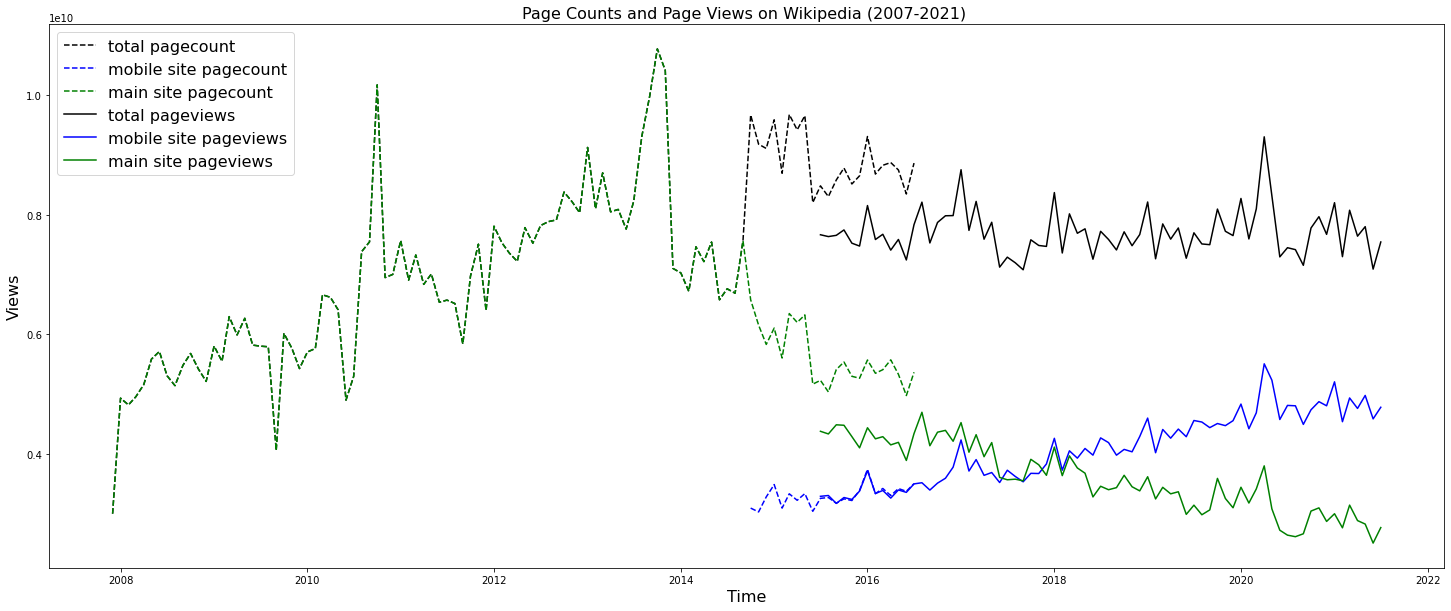

In [10]:
fig, ax = plt.subplots()
final_df['timestamp'] = final_df['year'] + final_df['month'] + '01'
final_df['timestamp'] = pd.to_datetime(final_df['timestamp'])
ax.plot_date(final_df['timestamp'], final_df['pagecount_all_views'], '--', color='black', label='total pagecount')
ax.plot_date(final_df['timestamp'], final_df['pagecount_mobile_views'], '--', color='blue', label='mobile site pagecount')
ax.plot_date(final_df['timestamp'], final_df['pagecount_desktop_views'], '--',color='green', label = 'main site pagecount')

ax.plot_date(final_df['timestamp'], final_df['pageview_all_views'], '-', color='black', label='total pageviews')
ax.plot_date(final_df['timestamp'], final_df['pageview_mobile_views'], '-', color='blue', label='mobile site pageviews' )
ax.plot_date(final_df['timestamp'], final_df['pageview_desktop_views'], '-',color='green', label='main site pageviews')

plt.title('Page Counts and Page Views on Wikipedia (2007-2021) ', fontsize=16);
plt.xlabel('Time');
plt.ylabel('Views');
ax.legend(loc='upper left');

plt.savefig('results/final_ts_graph.png')